# Bayesian statistics - extra practise

Notebook putting the excellent Machine lectures of Nando de Freitas in code/(LA)tex(t). We are dealing with Bayesian statistics. This is an extra notebook not covering any lectures of Nando.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt
import matplotlib.pyplot as plt
import scipy.stats as stats

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.


In [2]:
PATH_DATA = 'C:\\Users\\Egbert\\datascience\\ubc_ml\\data\\'

In this notebook we use PyMC3 again. This module is basically a collection of **theano** symbolic expressions for various probability distributions that are combined to one big compute graph making up the whole model log probability, and a collection of inference algorithms that use that graph to compute probabilities and gradients. For practical purposes, what this means is that in order to build certain models we sometimes have to use theano. 

### case : Whatsapp messages

Let's assume these are fictitious whatsapp messages over a period of 75 days. Is there a relevant increase in messages / change in behavior over time and can we detect this by using Bayesian techniques? Let's first the counts per day and plot: 

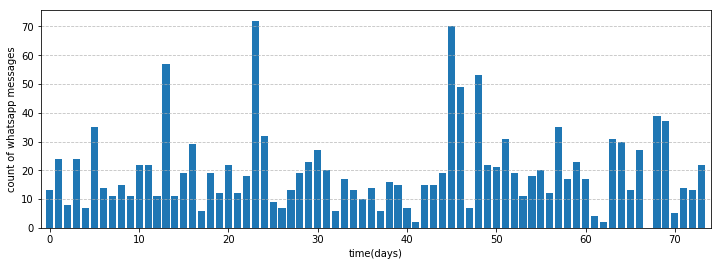

In [6]:
fig, ax = plt.subplots(figsize= [12,4])
whatsapp_count = np.loadtxt(PATH_DATA + 'txtdata.csv')
n_count_data = len(whatsapp_count)
ax.bar(np.arange(n_count_data), whatsapp_count)
ax.set(xlabel = 'time(days)', ylabel='count of whatsapp messages', xlim = (-1, n_count_data));
plt.grid(axis='y', linestyle= '--', alpha=.8)

Aften Poisson random variables are very appropriate models for this type of count data. Denoting day $i$'s whatsapp-message count by $C_i$,
$$ C_i \sim \text{Poisson}(\lambda)  $$

(Recall that a higher value of $\lambda$ assigns more probability to larger outcomes = higher probability of many messages on a given day.)

How can we represent mathematically? Let's assume that on some day during the observation period (say $\tau$), the parameter $\lambda$ suddenly jumps to a higher value. This implies we have 2 $\lambda$ parameters: one for the period before $\tau$, and one for the rest of the observation period. In the literature, a sudden transition like this would be called a switchpoint:
$$
\lambda = 
\begin{cases}
\lambda_1  \text{if } t \lt \tau \cr
\lambda_2  \text{if } t \ge \tau
\end{cases}
$$

If, in reality, no sudden change occurred and indeed $\lambda_1 = \lambda_2$, then **the $\lambda$s posterior distributions should look about equal**.


We are interested in inferring the unknown $\lambda$s. To use Bayesian inference, we need to assign prior probabilities to the different possible values of $\lambda$. What would be good prior probability distributions for $\lambda_1$ and $\lambda_2$? Recall that $\lambda$ can be any positive number. **The exponential distribution provides a continuous density function for positive numbers**, so this might be a good choice for modeling $\lambda_i$. But recall that the exponential distribution takes a parameter of its own, so we'll need to include that parameter in our model. Let's call that parameter $\alpha$.

$$\begin{align}
\lambda_1 \sim \text{Exp}( \alpha ) \\\
\lambda_2 \sim \text{Exp}( \alpha )
\end{align}$$

$\alpha$ is called a hyper-parameter and influences other parameters. Our initial guess at $\alpha$ does not influence the model too strongly, so we have some flexibility in our choice. A good rule of thumb is to set the exponential parameter equal to the inverse of the average of the count data. Since we're modeling $\lambda$ using an exponential distribution, we can use the expected value identity shown earlier to get:
$$\frac{1}{N}\sum_{i=0}^N \;C_i \approx E[\; \lambda \; |\; \alpha ] = \frac{1}{\alpha}$$
An alternative would be to have 2 priors: one for each $\lambda_i$. Creating two exponential distributions with different $\alpha$s reflects our prior belief that the rate changed at some point during the observations.
What about $\tau$? Because of the noisiness of the data, it's difficult to pick out a priori when $\tau$ might have occurred. Instead, we can assign a uniform prior belief **(Discrete Uniform distribution)** to every possible day. This is equivalent to saying:

$$\begin{align}
\tau \sim \text{DiscreteUniform(1,70) }\\\\
\Rightarrow P( \tau = k ) = \frac{1}{70}
\end{align}$$

So after all this, what does our overall prior distribution for the unknown variables look like? Frankly, it doesn't matter. What we should understand is that it's an ugly, complicated mess involving complicated symbols. Things will only get uglier the more complicated our models become. Regardless, all we really care about is the posterior distribution.
Let's get PyMC3 to the rescue again: 

In [7]:
with pm.Model() as model:
    alpha = 1.0/whatsapp_count.mean() # count of our whatsapp messages
    lambda_1 = pm.Exponential('lambda_1', alpha)
    lambda_2 = pm.Exponential('lambda_2', alpha)
    
    tau = pm.DiscreteUniform('tau', lower =0 , upper= n_count_data -1)

We just created the PyMC3 variables $\lambda_1$ + $\lambda_2$. We assign them to PyMC3's **stochastic variables**, so-called because they are treated by the back end as random number generators.

In [8]:
with model:
    idx = np.arange(n_count_data) # index
    lambda_ = pm.math.switch(tau >= idx, lambda_1, lambda_2)

Here we created a new function 'lambda', but really we can think of it as a random variable: same as the random variable $\lambda$ from above. The switch() function assigns lambda_1 or lambda_2 as the value of 'lambda', depending on what side of tau we are on. Lambda_1, lambda_2 and tau are random, so 'lambda' will also be random. No variables are fixed yet.

In [9]:
# The variable observation combines our data, count_data, with our proposed data-generation 
# scheme, given by the variable lambda_, through the observed keyword:
with model:
    observation = pm.Poisson('obs', lambda_, observed = whatsapp_count)

Markov Chain Monte Carlo (MCMC) returning thousands of random variables from the posterior distributions of $\lambda_1, \lambda_2$ and $\tau$.

In [10]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000,step=step)

100%|████████████████████████████████████| 15000/15000 [05:35<00:00, 44.73it/s]


In [12]:
trace.varnames

['lambda_1_log__', 'lambda_2_log__', 'tau', 'lambda_1', 'lambda_2']

In [11]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

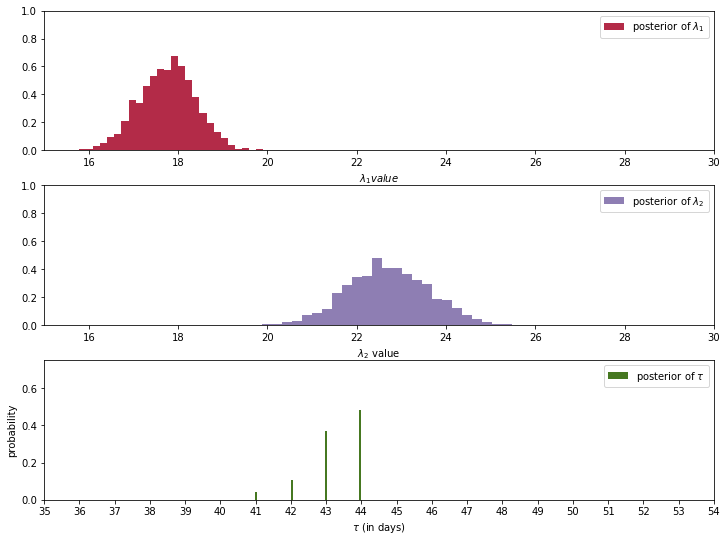

In [13]:
fig, ax  = plt.subplots(3,1, figsize= [12,9])
fig.subplots_adjust(hspace=0.25)

ax[0].hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
           label="posterior of $\lambda_1$", color="#A60628", normed=True)
ax[0].set(xlim = [15,30], ylim = [0,1], xlabel = '$\lambda_1 value$')
ax[0].legend(loc="upper right")

ax[1].hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
           label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
ax[1].legend(loc="upper right")
ax[1].set(xlim = [15, 30], ylim = [0,1], xlabel = "$\lambda_2$ value")

w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
ax[2].hist(tau_samples, bins=n_count_data, alpha=1,
           label=r"posterior of $\tau$",
           color="#467821", weights=w, rwidth=2.)
ax[2].set(xticks = (np.arange(n_count_data)), ylim = [0, .75], xlim = [35, len(whatsapp_count)-20] ,
          xlabel = r"$\tau$ (in days)", ylabel = "probability");
ax[2].legend(loc="upper right");

**How do we interpet these plots ?**

Bayesian methodologies return distributions and here we have distributions to describe the unknown $\lambda$s and $\tau$. Advantage is we immediately see the uncertainty in our estimates: wider distributions refer to a less certain posterior belief. We can also see what the plausible values for the parameters are: $\lambda_1$ is around 18 and $\lambda_2$ is around 23. The posterior distributions of the two $\lambda$s are clearly distinct, indicating that it is indeed likely that there was a change in the user's text-message behaviour.

Note that the posterior distributions for the $\lambda$s do not look like exponential distributions, even though our priors for these variables were exponential. In fact, the posterior distributions are not really of any form that we recognize from the original model. That's OK! This is one of the benefits of taking a computational point of view. If we had instead done this mathematically, we would have been stuck with an analytically intractable (c.q. messy) distribution. 

Our analysis also returned a distribution for $\tau$. Its posterior distribution looks a little different from the other two because it is a _discrete random variable_, so it doesn't assign probabilities to intervals. We can see that near day 44/45, there was a 50% chance that the user's behaviour changed. Had no change occurred, or had the change been gradual over time, the posterior distribution of $\tau$ would have been more spread out, reflecting that many days were plausible candidates for $\tau$. By contrast, in the actual results we see that only three or four days make any sense as potential transition points.

We'll use the posterior samples to answer the following question: what is the expected number of whatsapps at day $t, \; 0 \le t \le 70$ ? Recall that the expected value of a Poisson variable is equal to its parameter $\lambda$. So the question is equivalent to what is the expected value of $\lambda$ at time $t$?

In the code below, let $i$ index samples from the posterior distributions. Given a day $t$, we average over all possible $\lambda_i$ for that day $t$, using $\lambda_i = \lambda_{1,i}$ if $t \lt \tau_i$ (that is, if the behaviour change has not yet occurred), else we use $\lambda_i = \lambda_{2,i}$.

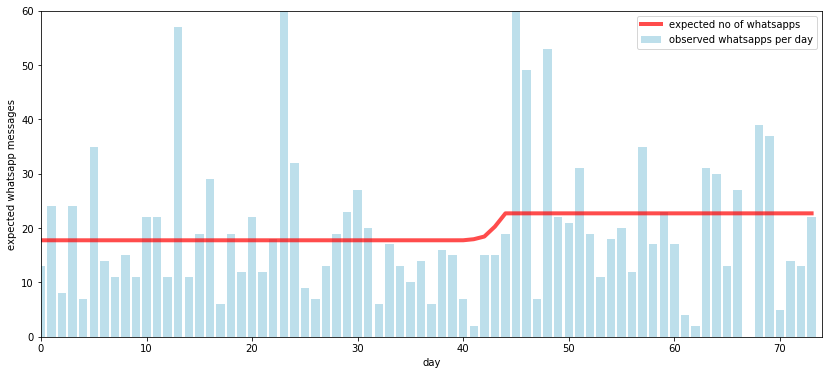

In [14]:
fig, ax  = plt.subplots(figsize= [14,6])

N = tau_samples.shape[0]
expected_whatsapps_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    """
    Each posterior sample corresponds to a value for tau.
    for each day, that value of tau indicates whether we're "before"
    (in the lambda1 "regime") or
    "after" (in the lambda2 "regime") the switchpoint.
    """
    ix = day < tau_samples
    expected_whatsapps_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N
    
ax.plot(range(n_count_data), expected_whatsapps_per_day, lw=4, color = 'red', alpha=.7 ,
        label ='expected no of whatsapps')
ax.bar(np.arange(len(whatsapp_count)), whatsapp_count, color="lightblue", alpha=0.8,
       label="observed whatsapps per day")
ax.set(xlim = [0, n_count_data], ylim = [0,60], xlabel ='day', ylabel = 'expected whatsapp messages')
ax.legend(loc = 'upper right')

### Case: A/B testing

Assume that there is some true $0 \lt p_A \lt 1$ probability that users who, upon shown site A, eventually purchase from the site (or convert or whatever). This is the true effectiveness of site A. Currently, this quantity is unknown to us.

Suppose site A was shown to $N$ people, and $n$ people purchased from the site. One might conclude hastily that $p_A = \frac{n}{N}$. Unfortunately, the observed frequency $\frac{n}{N}$ does not necessarily equal $p_A$ -- there is a difference between the observed frequency and the true frequency of an event.

To setup a Bayesian model, we need to assign prior distrbutions to our unknown quantities. A priori, what do we think $p_A$ might be? For this example, we have no strong conviction about $p_A$, so for now, let's assume $p_A$ is uniform over [0,1]:

In [15]:
with pm.Model() as model:
    p = pm.Uniform('p', lower=0 , upper=1) # bounds of the uniform

For this example, consider $p_A = 0.05$, and $N = 1500$ users shown site A, and we will simulate whether the user made a purchase or not. To simulate this from $N$ trials, we will use a Bernoulli distribution: if  $X\ \sim \text{Ber}(p)$, then $X$ is 1 with probability $p$ and 0 with probability $1 - p$. Of course, in practice we do not know $p_A$, but we will use it here to simulate/generate the data.

In [17]:
p_true = .05 # this value is unknown in reality
N = 1500

# sample N Bernoulli random variables from Ber(0.05) meaning each random 
# variable has a 0.05 chance of being a 1.
occurrences = stats.bernoulli.rvs(p_true, size=N) # rvs: Random variates

In [23]:
# Occurrences.mean() is equal to n/N.
print("What is the observed frequency in Group A? %.4f" % np.mean(occurrences))
print("Does this equal the true frequency? %s" % (np.mean(occurrences) == p_true))

What is the observed frequency in Group A? 0.0493
Does this equal the true frequency? False


Let's combine these observations into the PyMC3 observed variable, and run inference algorithm:

In [24]:
#include the observations, which are Bernoulli
with model:
    obs = pm.Bernoulli("observed", p, observed=occurrences)
    # To be explained in chapter 3
    step = pm.Metropolis()
    trace = pm.sample(18000, step=step)
    burned_trace = trace[1000:]

100%|████████████████████████████████████| 18500/18500 [04:06<00:00, 75.20it/s]


At this point, it may not look like it, but we have fully specified our priors. For example, we can ask and answer questions like: "What does my prior distribution of $\lambda_1$ look like?"

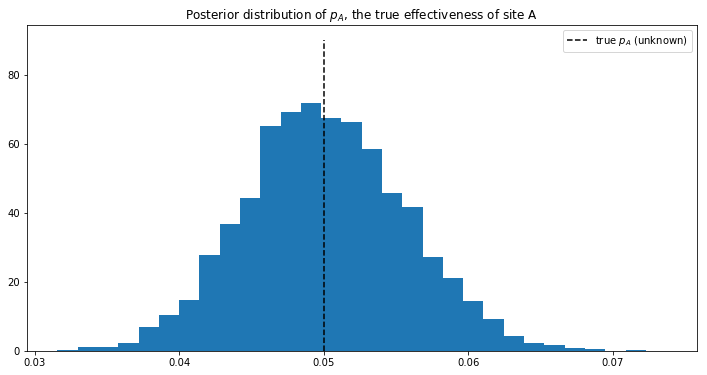

In [28]:
# plot the posterior distribution of the unknown P_A
fix, ax = plt.subplots(figsize= [12,6])
ax.vlines(p_true, 0, 90, linestyle = '--', label="true $p_A$ (unknown)")
ax.hist(burned_trace['p'], bins=30, histtype = 'stepfilled', normed= True)
ax.set(title = "Posterior distribution of $p_A$, the true effectiveness of site A")
ax.legend(loc='upper right')

The posterior distribution puts most weight near the true value of $p_A$, but also some weights in the tails (measure of uncertainty given our observations. We can change the number of observations, N, and observe how the posterior distribution changes.

**Combining site A and B**

Let's also simulate response data for a second site B to determine $P_{b}$. Let's infer $p_A$, $p_B$, and $\text{delta} = p_A - p_B$, all at once: 

(Notice by the way the unequal sample size N_A and N_B. This poses no problem for us in Bayesian statistics!)

In [3]:
# Quantities unknown to us:
true_p_A = 0.05
true_p_B = 0.04

N_A = 1650
N_B = 720

# generate observations:
observations_A = stats.bernoulli.rvs(true_p_A, size= N_A)
observations_B = stats.bernoulli.rvs(true_p_B, size= N_B)

In [4]:
## print some :
print("Observations from site A: ", observations_A[:30], "...")
print("Observations from site B: ", observations_B[:30], "...")
print ('\n')
print('Average of the observations of site A: {}' .format(np.mean(observations_A)))
print('Average of the observations of site B: {}' .format(np.mean(observations_B)))

Observations from site A:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] ...
Observations from site B:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0] ...


Average of the observations of site A: 0.04909090909090909
Average of the observations of site B: 0.04861111111111111


In [40]:
# Set up the pymc3 model. Again assume Uniform priors for p_A and p_B. (runs long time w/o )
with pm.Model() as model:
    p_A = pm.Uniform('p_A', 0, 1)
    p_B = pm.Uniform('p_B', 0, 1)
    
    # Define the deterministic delta function. This is our unknown of interest.
    delta = pm.Deterministic("delta", p_A - p_B)
    
    # Set of observations, in this case we have two observation datasets.
    obs_A = pm.Bernoulli('obs_A', p_A, observed = observations_A)
    obs_B = pm.Bernoulli('obs_B', p_B, observed = observations_B)
    
    step = pm.Metropolis()
    trace = pm.sample(20000, step = step)
    partial_trace=trace[1000:]

100%|████████████████████████████████████| 20500/20500 [07:21<00:00, 44.07it/s]


In [41]:
p_A_samples = partial_trace["p_A"]
p_B_samples = partial_trace["p_B"]
delta_samples = partial_trace["delta"]

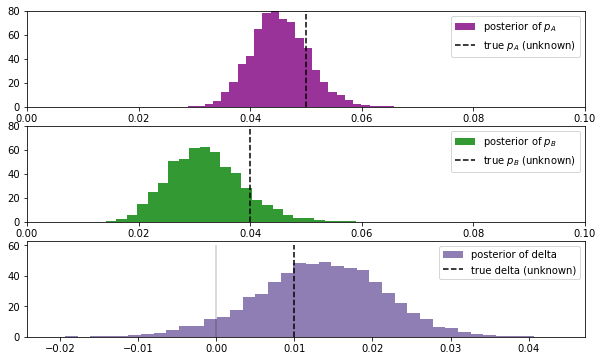

In [58]:
fig, ax = plt.subplots(3,1, figsize = [10,6])

ax[0].hist(p_A_samples, histtype ='stepfilled', bins=25, alpha =.8, 
           label="posterior of $p_A$", color = 'purple', normed= True)
ax[0].vlines(true_p_A, 0, 80, linestyle="--", label="true $p_A$ (unknown)")
ax[0].set(xlim = [0, .1], ylim = [0,80])
ax[0].legend(loc='upper right')

ax[1].hist(p_B_samples, histtype ='stepfilled', bins=25, alpha =.8, 
           label="posterior of $p_B$", color ='green', normed= True)
ax[1].vlines(true_p_B, 0, 80, linestyle="--", label="true $p_B$ (unknown)")
ax[1].set(xlim = [0, .1], ylim = [0,80])
ax[1].legend(loc='upper right')

ax[2].hist(delta_samples, histtype='stepfilled', bins=40, alpha=0.85,
         label="posterior of delta", color="#7A68A6", normed=True)
ax[2].vlines(true_p_A - true_p_B, 0, 60, linestyle="--",
           label="true delta (unknown)")
ax[2].vlines(0, 0, 60, color="black", alpha=0.2)
ax[2].legend(loc="upper right");

Because N_B (720) < N_A (1650), we have less data from site B, so our posterior distribution of $p_B$ is wider, implying we are less certain about the true value of $p_B$.

With respect to the posterior distribution of $\text{delta}$, we can see that the majority of the distribution is above $\text{delta}=0$, so site A's response is likely better compared to B. The probability this inference is incorrect is easily computable:

In [59]:
# Count the number of samples less than 0, i.e. the area under the curve
# before 0, represent the probability that site A is worse than site B.
print("Probability site A is WORSE than site B: %.3f" % \
    np.mean(delta_samples < 0))

print("Probability site A is BETTER than site B: %.3f" % \
    np.mean(delta_samples > 0))

Probability site A is WORSE than site B: 0.059
Probability site A is BETTER than site B: 0.941


This probability is very high for comfortable decision-making, so we could perform more trials on site B (since this site has less samples we need more of these because each point for site B contributes more inferential "power" than each additional data point for site A).

It's interesting to change the parameters true_p_A, true_p_B, N_A, and N_B, to see what the posterior of $\text{delta}$ looks like. Notice in all this, the difference in sample sizes between site A and site B was never mentioned: it naturally fits into Bayesian analysis.

This style of A/B testing is more natural than hypothesis testing, which has probably confused more than helped practitioners. 

Source:
https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter2_MorePyMC/Ch2_MorePyMC_PyMC3.ipynb

### Case: stock returns

When choosing which stocks to pick, quants will often look at the daily return : suppose $S_t$ is the price of the stock on day $t$, so daily return on day $t$ is :

$$r_t = \frac{ S_t - S_{t-1} }{ S_{t-1} } $$

The expected daily return of a stock is denoted $\mu = E[ r_t ]$. Obviously, stocks with high expected returns are desirable. Unfortunately, stock returns are so filled with noise that it is very hard to estimate this parameter.

Furthermore, the parameter might change over time so it is unwise to use a large historical datasets.
Historically, the expected return has been estimated by using the sample mean. This is a bad idea. : the sample mean of a small sized dataset has enormous potential to be very wrong. Thus Bayesian inference is the correct procedure here, since we are able to see our uncertainty along with probable values.

Let's examen the daily returns of the AAPL, GOOG, MSFT and AMZN. Before we pull in the data, suppose we ask our a stock fund manager : What do you think the return profile looks like for each of these companies?
Our stock broker, without needing to know the language of Normal distributions, or priors, or variances, etc. creates four distributions using the **trial roulette** method above. Suppose they look enough like Normals, so we fit Normals to them. They may look like:

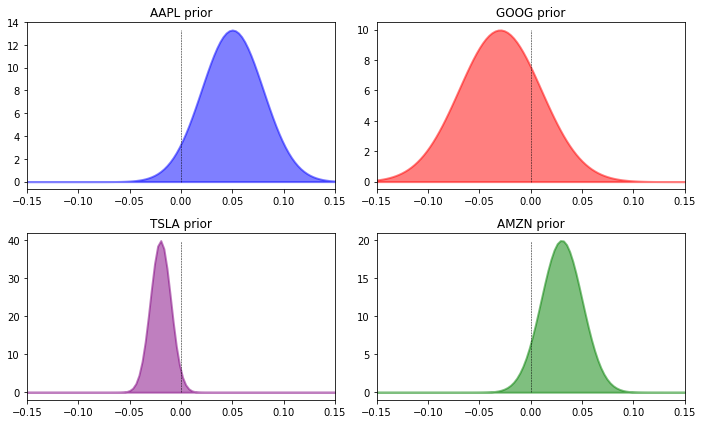

In [8]:
fig, ax = plt.subplots(2,2,figsize =[10,6])
colors = ["blue", "red", "purple", "green"]
params = [(0.05, 0.03), (-0.03, 0.04), (-0.02, 0.01), (0.03, 0.02)]

x = np.linspace(-0.15, 0.15, 100)
norm = stats.norm
expert_prior_params = {"AAPL":(0.05, 0.03),
                 "GOOG":(-0.03, 0.04), 
                 "TSLA": (-0.02, 0.01), 
                 "AMZN": (0.03, 0.02), 
                 }

for i, (name, params) in enumerate(expert_prior_params.items()):
    plt.subplot(2, 2, i+1)
    y = norm.pdf(x, params[0], scale = params[1])
    plt.fill_between(x, 0, y, color = colors[i], linewidth=2,
                     edgecolor = colors[i], alpha = 0.5)
    plt.title(name + " prior")
    plt.vlines(0, 0, y.max(), "k","--", linewidth = 0.5)
    plt.xlim(-0.15, 0.15)
plt.tight_layout()

In order to better model these returns, we can investigate the covariance matrix of the returns. F.i. it would be unwise to invest in two stocks that are highly correlated, since they are likely to sink together (hence why fund managers suggest a diversification strategy). We will use the **Wishart distribution** for this, introduced earlier.

Let's get some historical data for these stocks. We will use the covariance of the returns as a starting point for our Wishart random variable. This is not empirical bayes  because we are only deciding the starting point, not influencing the parameters.

In [16]:
# get an quandl account for API at: https://www.quandl.com/
import quandl
quandl.ApiConfig.api_key = 'sD_cyjj9w_3XnGSGHdK1'
auth_tok = 'sD_cyjj9w_3XnGSGHdK1'

In [30]:
stocks = ["AAPL", "GOOG", "TSLA", "AMZN"]
startdate = "2015-01-01"
enddate = "2017-08-30"

data =quandl.get_table('WIKI/PRICES', qopts = { 'columns': ['ticker', 'date', 'close'] }, 
                 ticker = stocks, 
                 date = {'gte': startdate, 'lte': enddate})
data = data.reset_index().drop('None', axis=1)

In [37]:
stock_closes = data.pivot_table(values='close', aggfunc='mean', index='date', columns='ticker')

In [38]:
stock_closes.head(2)

ticker,AAPL,AMZN,GOOG,TSLA
date,,,,
2015-01-02,109.33,308.52,524.81,219.31
2015-01-05,106.25,302.19,513.87,210.09


In [43]:
n_observations = 100 # we will truncate the the most recent 100 days.
stock_returns  = stock_closes.pct_change()[1:][-n_observations:]

In [45]:
import pymc3 as pm
import theano.tensor as tt
from theano.tensor.nlinalg import matrix_inverse, diag, matrix_dot

prior_mu = np.array([x[0] for x in expert_prior_params.values()])
prior_std = np.array([x[1] for x in expert_prior_params.values()])

init = stock_returns.cov()

with pm.Model() as model:
    cov_matrix = pm.WishartBartlett("covariance", np.diag(prior_std**2), 10, testval = init)

    mu = pm.Normal("returns", mu=prior_mu, sd=1, shape=4)

Added new variable c to model diagonal of Wishart.
Added new variable z to model off-diagonals of Wishart.


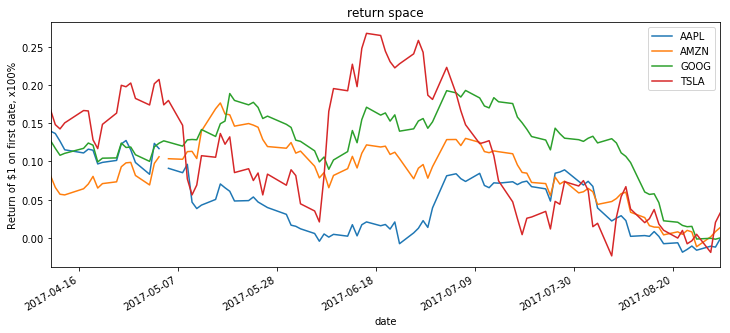

In [52]:
fig, ax = plt.subplots(figsize =[12,5])

cum_returns = np.cumprod(1 + stock_returns) - 1
cum_returns.index = stock_returns.index[::-1] #date index
cum_returns.plot(ax=ax)
ax.set(ylabel = "Return of $1 on first date, x100%", title = 'return space')
ax.legend(loc = "upper right")

In [63]:
for _stock , i in zip(stocks, ax.ravel()):
    print (i.)

AttributeError: 'AxesSubplot' object has no attribute 'shape'

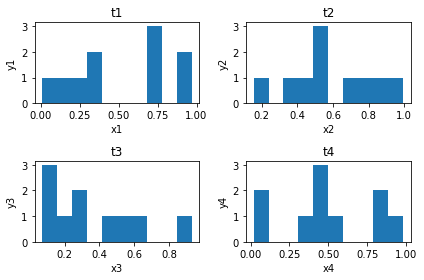

In [66]:
data=np.random.random((4,10))
xaxes = ['x1','x2','x3','x4']
yaxes = ['y1','y2','y3','y4']
titles = ['t1','t2','t3','t4'] 

f,a = plt.subplots(2,2)
a = a.ravel()
for idx,ax in enumerate(a):
    ax.hist(data[idx])
    ax.set_title(titles[idx])
    ax.set_xlabel(xaxes[idx])
    ax.set_ylabel(yaxes[idx])
plt.tight_layout()

In [83]:
stock_returns = stock_returns.fillna(0)

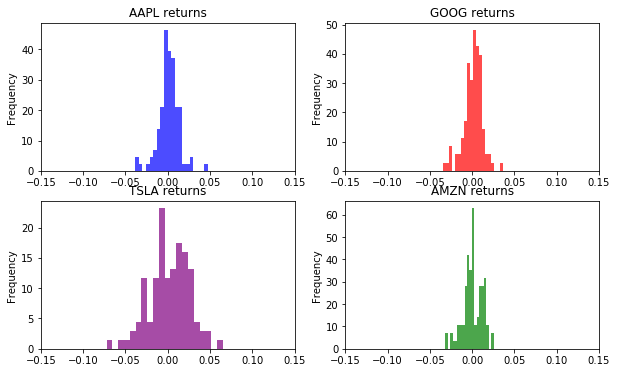

In [84]:
fig, ax = plt.subplots(2,2,figsize =[10,6])
ax = ax.ravel()

for i, _stock in enumerate(stocks):
    stock_returns[_stock].plot(kind ='hist', ax=ax[i], bins=20,
             normed = True, histtype="stepfilled",
             color=colors[i], alpha=0.7)
    ax[i].set(title = (_stock + " returns"), xlim = [-0.15, 0.15])

Below we perform the inference on the posterior mean return and posterior covariance matrix.

In [86]:
# pm.MvNormal = Multivariate normal log-likelihood.
with model:
    obs = pm.MvNormal("observed returns2", mu=mu, cov=cov_matrix, 
                      observed=stock_returns.values)
    step = pm.NUTS()
    trace = pm.sample(5000, step=step)

  0%|                                      | 14/5500 [00:32<7:57:14,  5.22s/it]C:\Users\Egbert\Anaconda3\lib\site-packages\pymc3\step_methods\hmc\nuts.py:418: UserWarning: Chain 0 contains only 0 samples.
  % (self._chain_id, n))
C:\Users\Egbert\Anaconda3\lib\site-packages\pymc3\step_methods\hmc\nuts.py:420: UserWarning: Step size tuning was enabled throughout the whole trace. You might want to specify the number of tuning steps.
  warnings.warn('Step size tuning was enabled throughout the whole '
C:\Users\Egbert\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)

